In [151]:
import pandas as pd
from sklearn.linear_model import LinearRegression

content = open("./hw3longley.txt", "r").read()

rows = content.split("\n")
arr = []
for r in rows:
    r = r.split()
    r = [float(v) for v in r]
    arr.append(r)

df = pd.DataFrame(
    arr, columns=["TOTEMP", "GNPDEFL", "GNP", "UNEMP", "ARMED", "POP", "YEAR"]
)


model = LinearRegression()
x = df.loc[:, df.columns != "TOTEMP"]
y = df.loc[:, "TOTEMP"]
model.fit(x, y)

r2_score = model.score(x, y)


arr = []
for ind, val in enumerate(model.coef_):
    arr.append(f"{round(val, 2)} * {df.columns[ind + 1]}")

model_str = f"TOTEMP = {round(model.intercept_, 2)} + " + (" + ").join(arr)

df_new = pd.DataFrame(columns=["YEAR", "% error of forecast"])

model.predict(df.loc[[0], df.columns != "TOTEMP"])

for ind in range(len(df)):
    df_new.loc[ind, "YEAR"] = int(df.at[ind, "YEAR"])
    estimate = model.predict(df.loc[[ind], df.columns != "TOTEMP"])[0]
    actual = df.at[ind, "TOTEMP"]
    df_new.loc[ind, "YEAR"] = int(df.at[ind, "YEAR"])
    df_new.loc[ind, "% error of forecast"] = round(
        100 * (actual - estimate) / actual, 2
    )
df_new

,GNPDEFL,GNP,UNEMP,ARMED,POP,YEAR
0,83.0,234289.0,2356.0,1590.0,107608.0,1947.0
1,88.5,259426.0,2325.0,1456.0,108632.0,1948.0
2,88.2,258054.0,3682.0,1616.0,109773.0,1949.0
3,89.5,284599.0,3351.0,1650.0,110929.0,1950.0
4,96.2,328975.0,2099.0,3099.0,112075.0,1951.0
5,98.1,346999.0,1932.0,3594.0,113270.0,1952.0
6,99.0,365385.0,1870.0,3547.0,115094.0,1953.0
7,100.0,363112.0,3578.0,3350.0,116219.0,1954.0
8,101.2,397469.0,2904.0,3048.0,117388.0,1955.0
9,104.6,419180.0,2822.0,2857.0,118734.0,1956.0


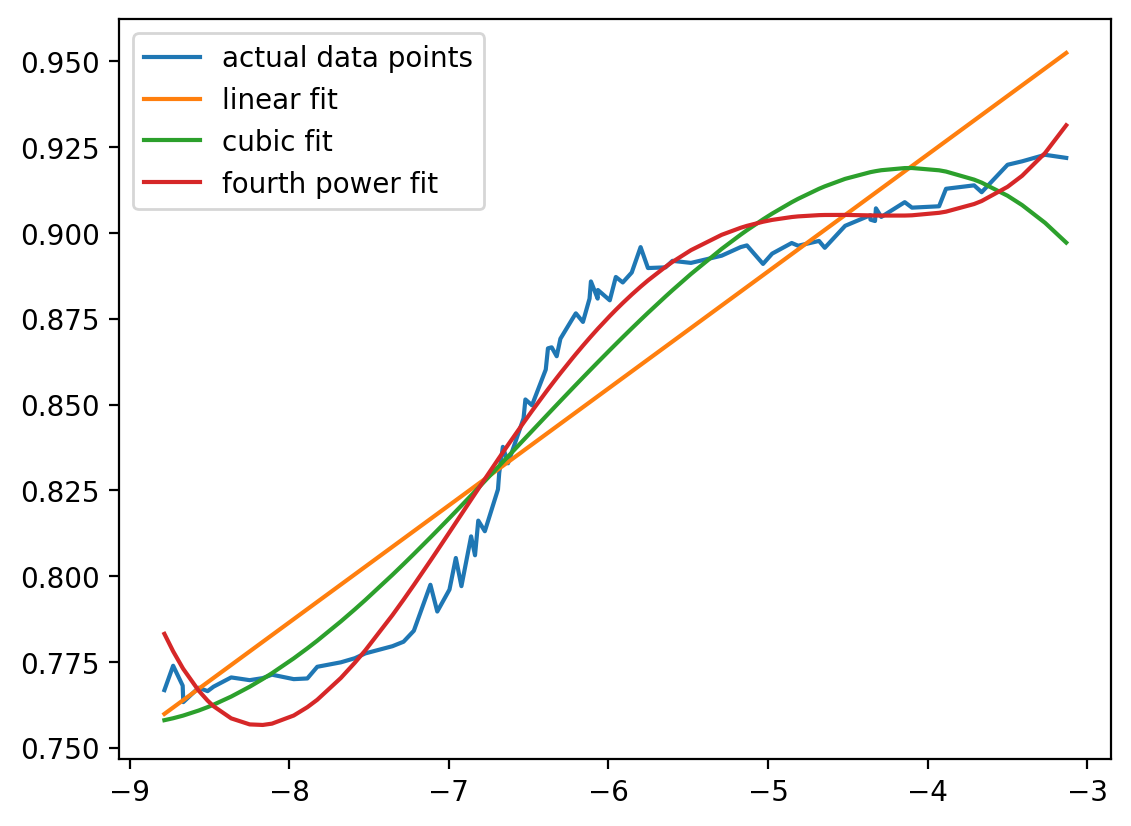

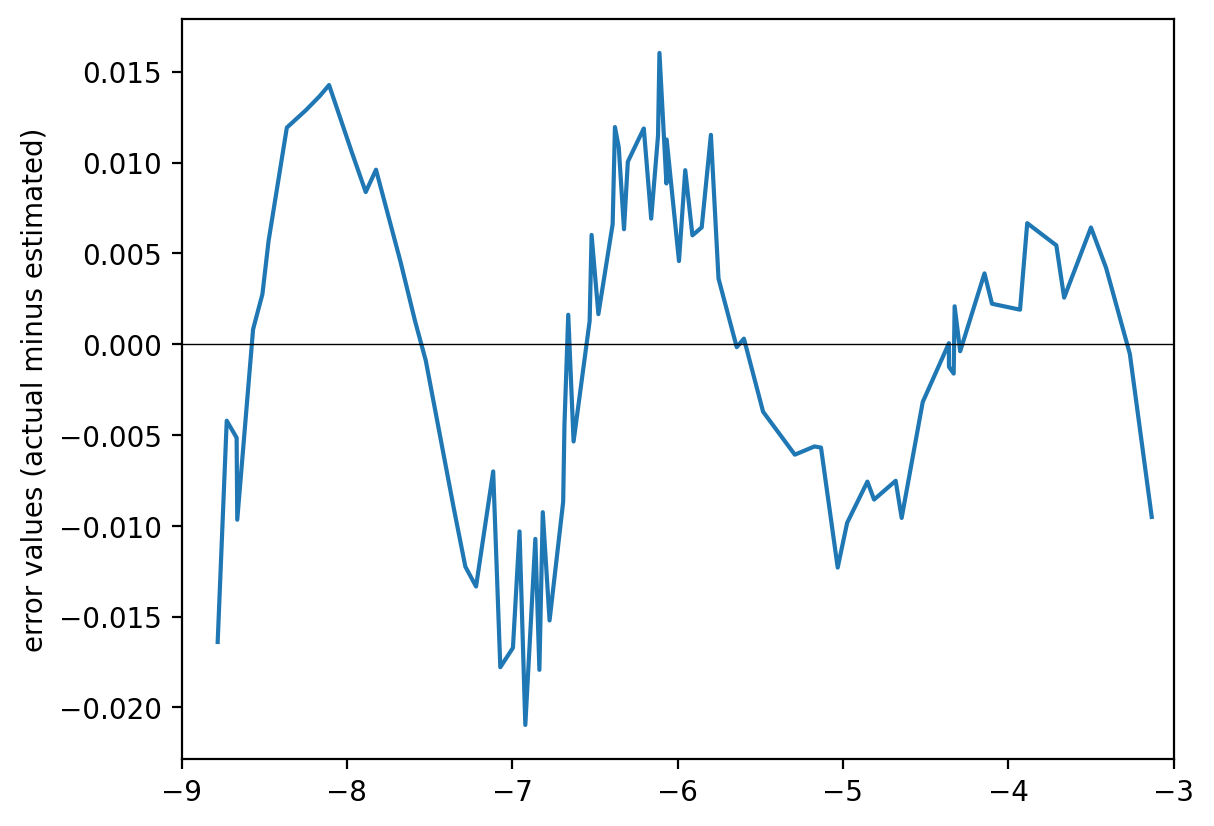

In [301]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures

%config InlineBackend.figure_format = 'retina'

df_filip = pd.read_csv("hw3filip.txt", header=None, sep="\s+")

linear_fit = LinearRegression()
y = df_filip.loc[:, 0]
x = (df_filip.loc[:, 1]).to_frame()
linear_fit.fit(x, y)

x_sorted, y_sorted = [list(t) for t in zip(*sorted(zip(x.values, y.values)))]

fig, ax = plt.subplots()
ax.plot(x_sorted, y_sorted, label="actual data points")
ax.plot(x_sorted, linear_fit.predict(x_sorted), label="linear fit")

# quadratic = PolynomialFeatures(degree=2, include_bias=False)
# quadratic_features = quadratic.fit_transform(x_sorted, y_sorted)
# quadratic_fit = LinearRegression()
# quadratic_fit.fit(quadratic_features, y_sorted)
# ax.plot(x_sorted, quadratic_fit.predict(quadratic_features), label="quadratic fit")


cubic = PolynomialFeatures(degree=3, include_bias=False)
cubic_features = cubic.fit_transform(x_sorted, y_sorted)
cubic_fit = LinearRegression()
cubic_fit.fit(cubic_features, y_sorted)
ax.plot(x_sorted, cubic_fit.predict(cubic_features), label="cubic fit")

fourth = PolynomialFeatures(degree=4, include_bias=False)
fourth_features = fourth.fit_transform(x_sorted, y_sorted)
fourth_fit = LinearRegression()
fourth_fit.fit(fourth_features, y_sorted)
ax.plot(x_sorted, fourth_fit.predict(fourth_features), label="fourth power fit")

ax.legend()
fig, ax2 = plt.subplots()
ax2.plot(x_sorted, y_sorted - fourth_fit.predict(fourth_features))
ax2.hlines([0], -10, 2, color="black", linewidths=[0.5])
ax2.set_xlim(-9, -3)
ax2.set_ylabel("error values (actual minus estimated)");

The fourth degree polynomial shows errors that tend to stay positive or negative for a period of time resembling positive autocorrelation. This is likely because the fourth degree polynomial isn't actually the *true* relationship of the variables. The true relationship doesn't look to be polynomial at all really, and increasing the polynomial degree isn't then necessarily going to provide a better model, it would just overfit to noise in the data. I'd expect the true relationship more to resemble a logistic function.

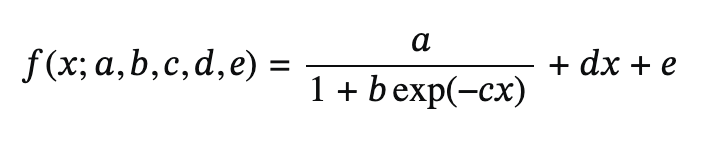

[-9.10199455e-02  2.83145501e+01 -5.20795526e+00  1.13686909e-02
  8.86499946e-01]


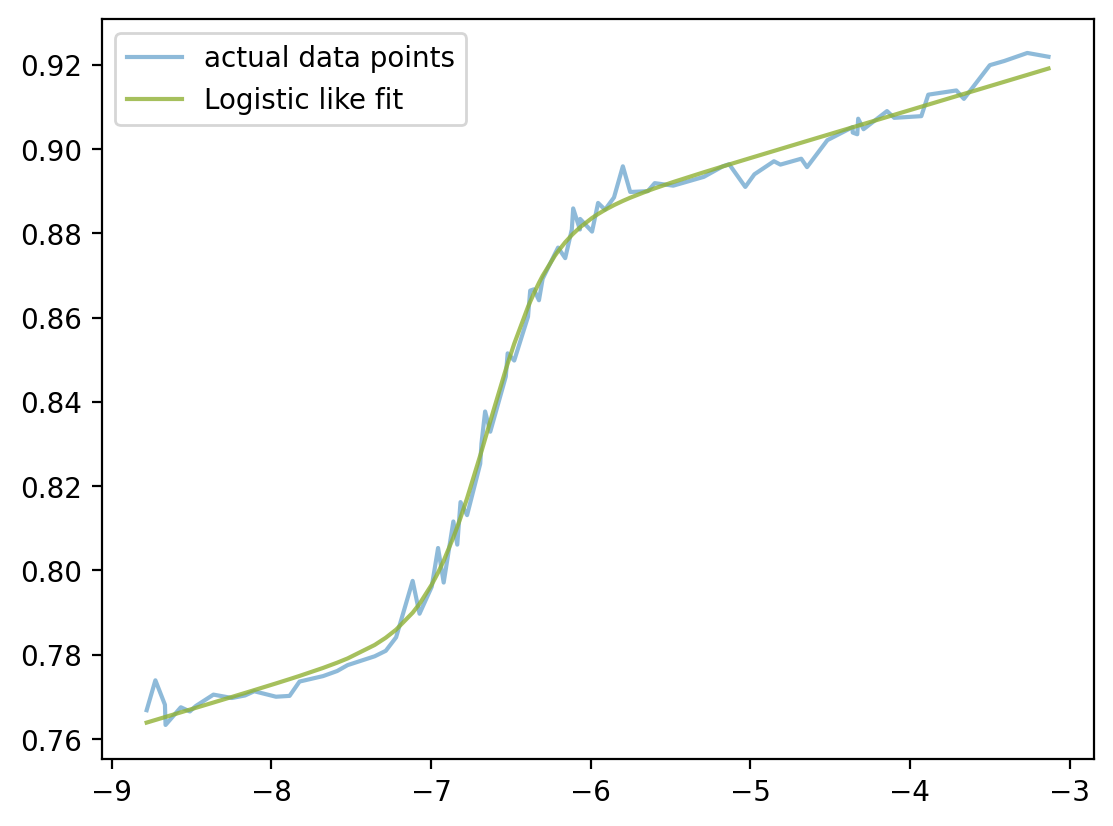

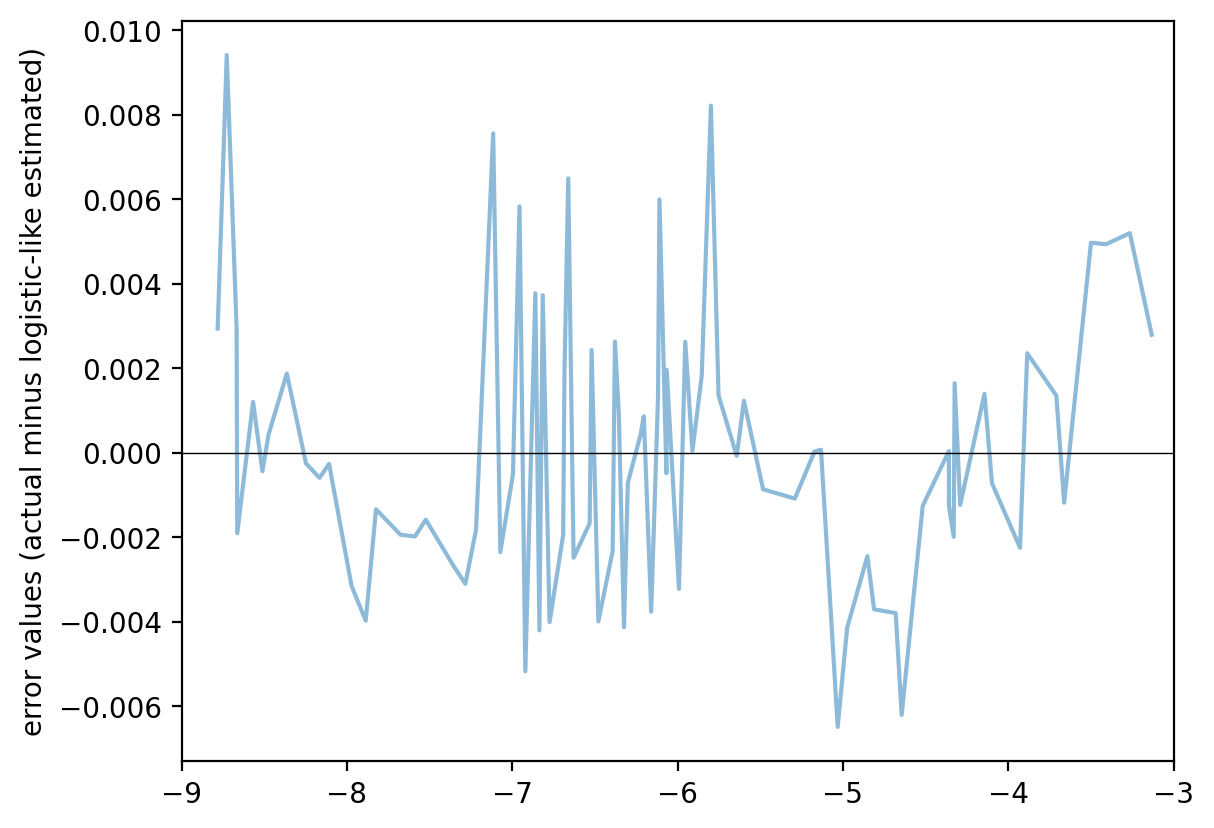

In [269]:
import numpy as np
import scipy.optimize as opt


def logistic_like(x, a, b, c, d, e):
    return (a / (1 + b * np.exp(-c * (x + 6)))) + d * (x + 6) + e


x_arr = np.array(x_sorted).flatten()
y_arr = np.array(y_sorted).flatten()

# curve fitting
popt, pcov = opt.curve_fit(
    logistic_like,
    x_arr,
    y_arr,
    [1, 10, 20, 0.1, 1],
)

print(popt)

fig, ax = plt.subplots()
ax.plot(x_sorted, y_sorted, label="actual data points", alpha=0.5)
ax.plot(
    x_arr,
    logistic_like(x_arr, *popt),
    color="xkcd:avocado",
    label="Logistic like fit",
    alpha=0.8,
)
ax.legend()

fig, ax = plt.subplots()
ax.plot(
    x_sorted,
    y_sorted - logistic_like(x_arr, *popt),
    label="actual data points",
    alpha=0.5,
)
ax.hlines([0], -10, 2, color="black", linewidths=[0.5])
ax.set_xlim(-9, -3)
ax.set_ylabel("error values (actual minus logistic-like estimated)");

These residuals are closer to showing no pattern.

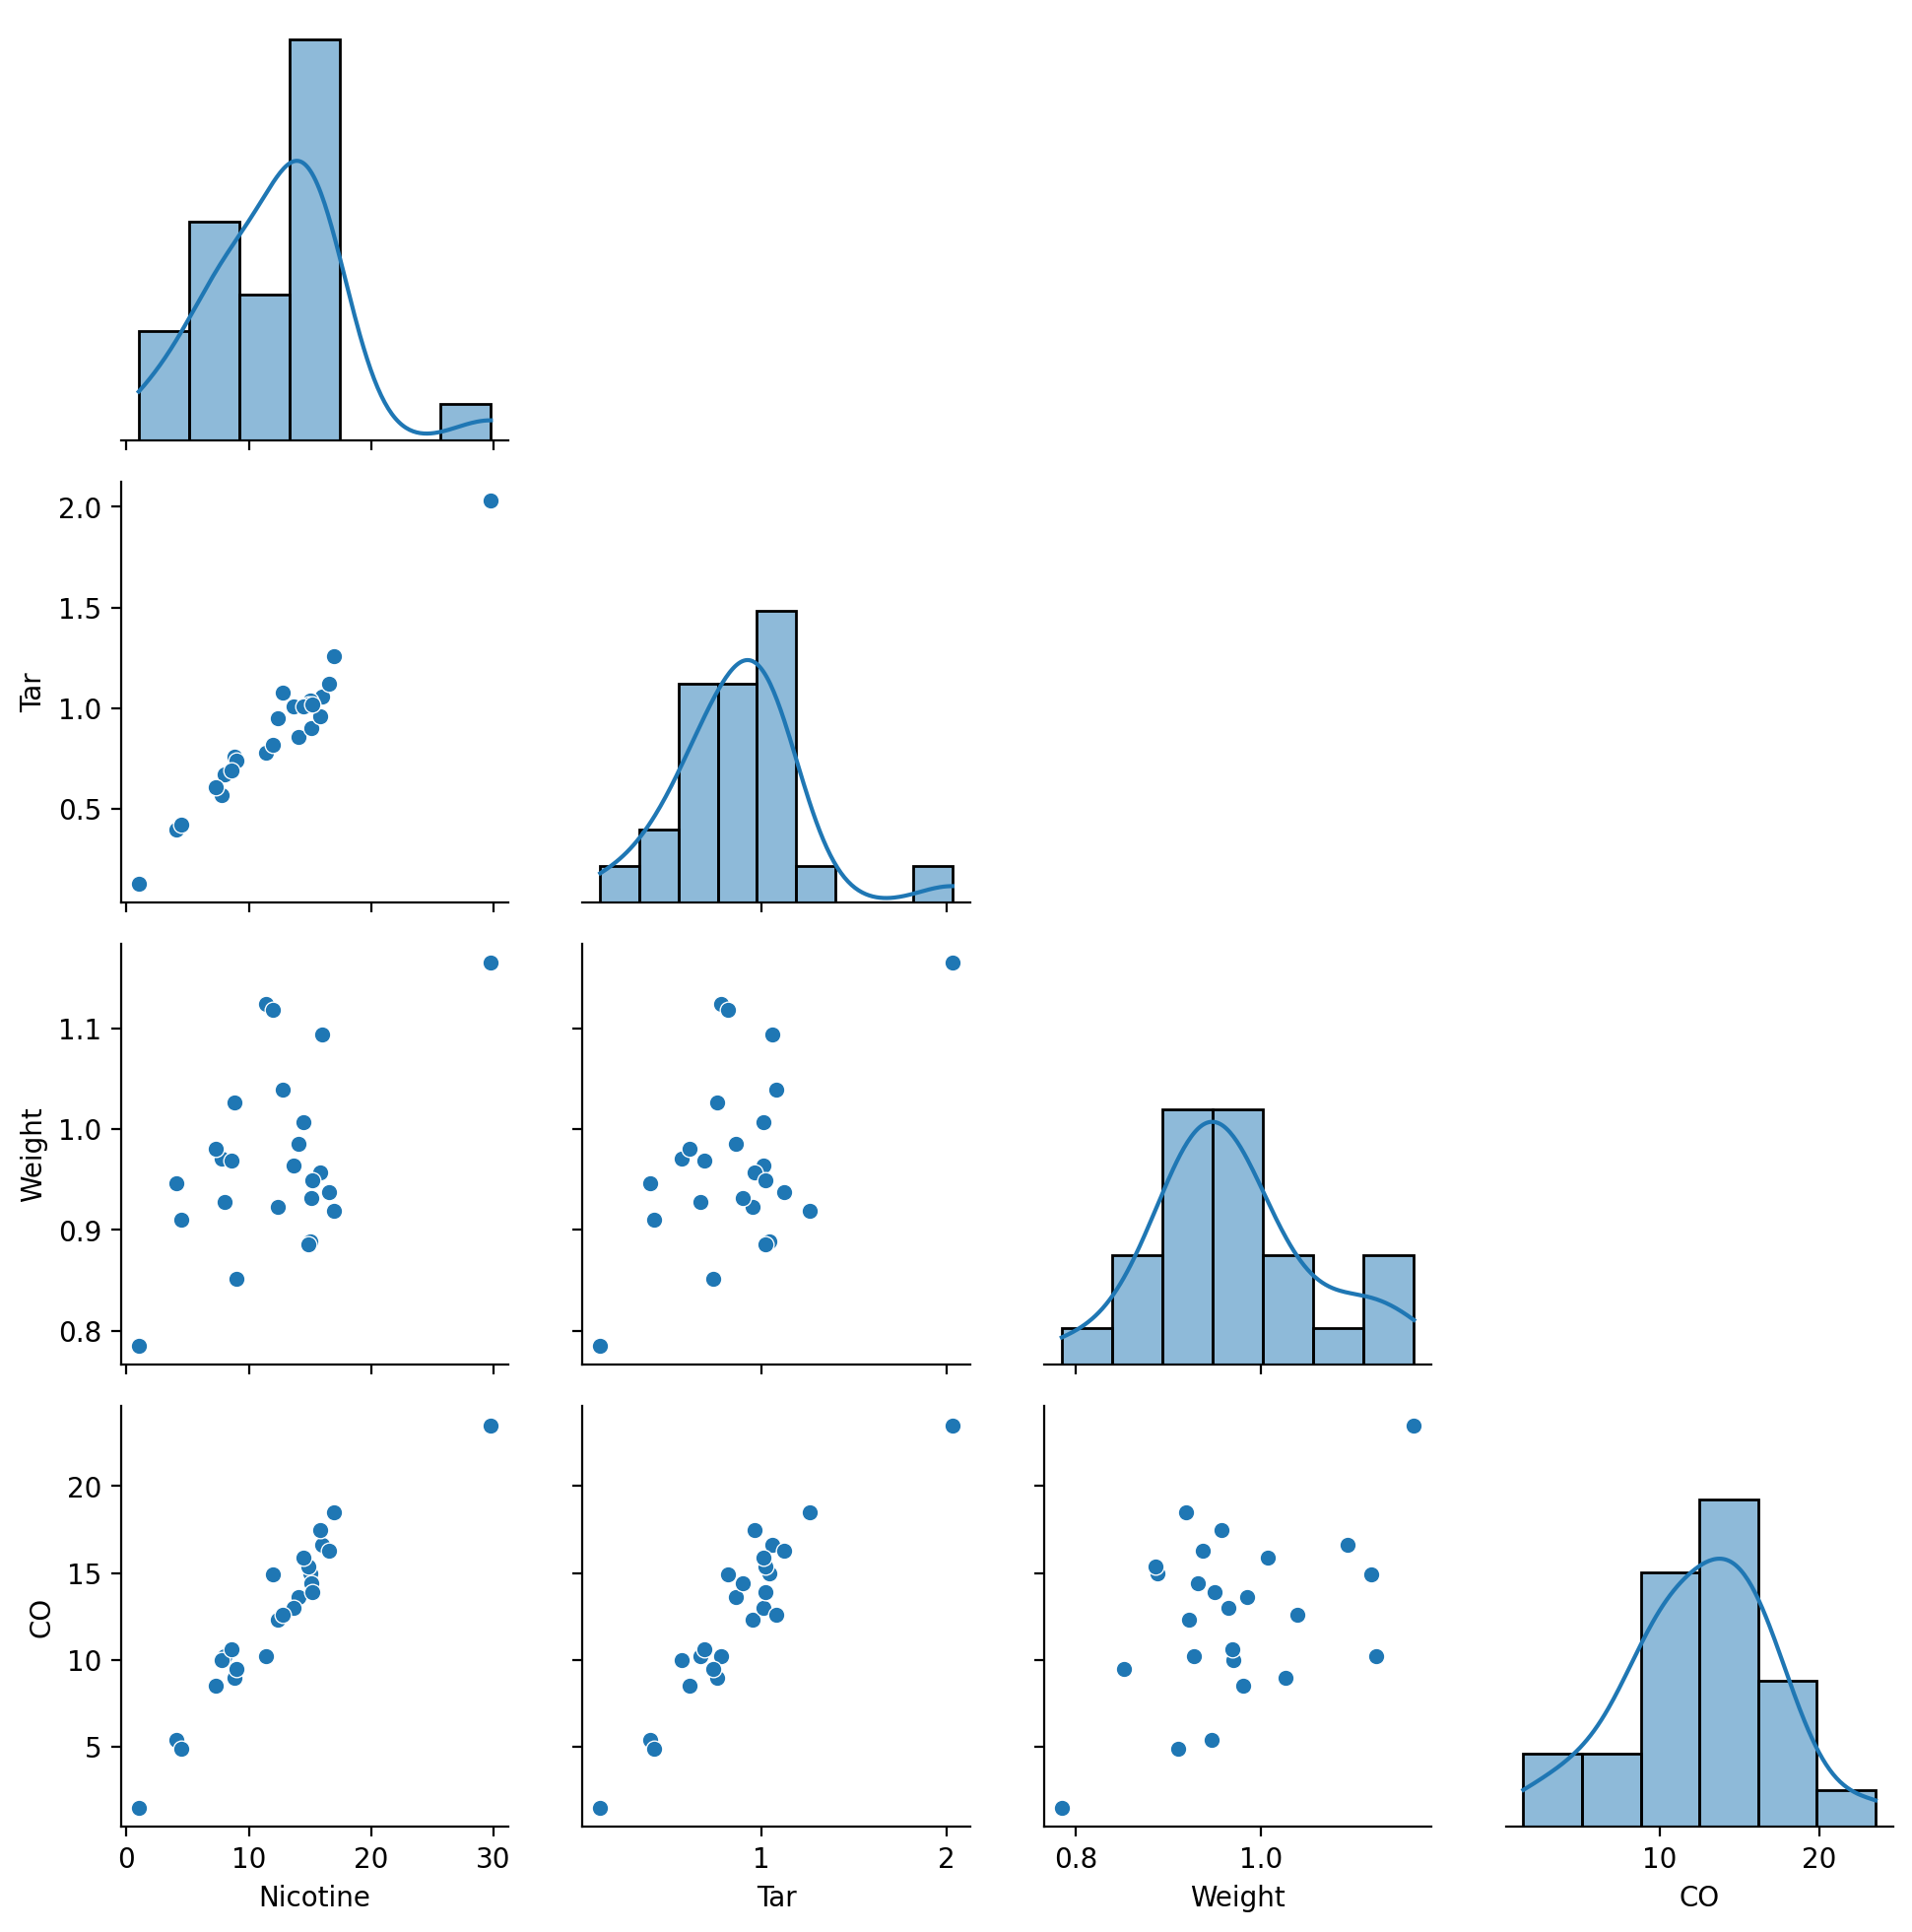

In [329]:
import seaborn as sns

df = pd.read_csv("./hw3cigarettes.csv")

g = sns.PairGrid(df, corner=True)
g.map_lower(sns.scatterplot)
g.map_diag(sns.histplot, kde=True)

In [331]:
df

,Brand,Nicotine,Tar,Weight,CO
0,Alpine,14.1,0.86,0.9853,13.6
1,Benson&Hedges,16.0,1.06,1.0938,16.6
2,BullDurham,29.8,2.03,1.1650,23.5
3,CamelLights,8.0,0.67,0.9280,10.2
4,Carlton,4.1,0.40,0.9462,5.4
5,Chesterfield,15.0,1.04,0.8885,15.0
6,GoldenLights,8.8,0.76,1.0267,9.0
7,Kent,12.4,0.95,0.9225,12.3
8,Kool,16.6,1.12,0.9372,16.3
9,L&M,14.9,1.02,0.8858,15.4


CO = 3.2 + 0.96 * Nicotine + -2.63 * Tar + -0.13 * Weight
0.9185893479475058
CO = 2.74 + 0.8 * Nicotine
0.9167781566169361


/var/folders/ht/kgx7l0rn2p5g_jl_0gn7njvm0000gn/T/ipykernel_56978/492229295.py:29: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '14.382689072604295' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.at[ind, "predicted CO"] = estimate
/var/folders/ht/kgx7l0rn2p5g_jl_0gn7njvm0000gn/T/ipykernel_56978/492229295.py:30: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-5.76' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.at[ind, "% error"] = round(100 * (actual - estimate) / actual, 2)


,Brand,Nicotine,CO,predicted CO,% error
0,Alpine,14.1,13.6,14.037039,-3.21
1,Benson&Hedges,16.0,16.6,15.558893,6.27
2,BullDurham,29.8,23.5,26.612361,-13.24
3,CamelLights,8.0,10.2,9.151085,10.28
4,Carlton,4.1,5.4,6.027279,-11.62
5,Chesterfield,15.0,15.0,14.757917,1.61
6,GoldenLights,8.8,9.0,9.791866,-8.80
7,Kent,12.4,12.3,12.675380,-3.05
8,Kool,16.6,16.3,16.039479,1.60
9,L&M,14.9,15.4,14.677820,4.69


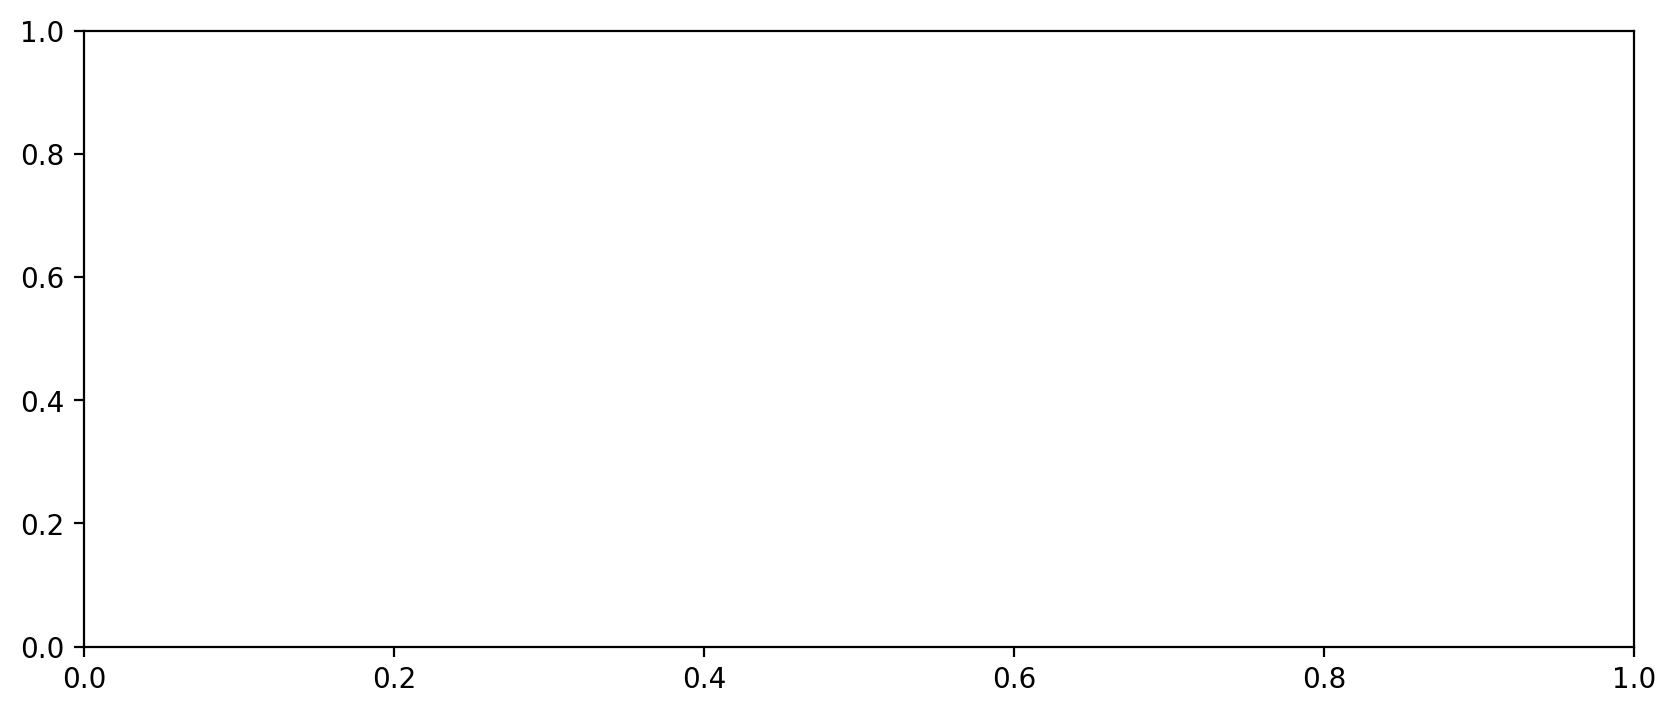

In [412]:
df = pd.read_csv("./hw3cigarettes.csv")


fig, ax = plt.subplots(figsize=(10, 4))


linear_fit = LinearRegression()
y = df.loc[:, "CO"]
x = df.loc[:, ~df.columns.isin(["CO", "Brand"])]
linear_fit.fit(x, y)

coeffs = [
    f"{round(val, 2)} * {df.columns[ind + 1]}"
    for ind, val in enumerate(linear_fit.coef_)
]


model_str = f"CO = {round(linear_fit.intercept_, 2)} + {(' + ').join(coeffs)}"

print(model_str)
print(linear_fit.score(x, y))
df.insert(5, "predicted CO", [0] * len(df))
df.insert(6, "% error", [0] * len(df))


for ind in range(len(df)):
    estimate = linear_fit.predict(x.iloc[[ind]])[0]
    actual = df.at[ind, "CO"]
    df.at[ind, "predicted CO"] = estimate
    df.at[ind, "% error"] = round(100 * (actual - estimate) / actual, 2)
df



df_nicotine = df.copy(deep=True)

linear_fit_nicotine = LinearRegression()
y = df.loc[:, "CO"]
x = df.loc[:, df.columns.isin(["Nicotine"])]
linear_fit.fit(x, y)

coeffs = [
    f"{round(val, 2)} * {df.columns[ind + 1]}"
    for ind, val in enumerate(linear_fit.coef_)
]


model_str = f"CO = {round(linear_fit.intercept_, 2)} + {(' + ').join(coeffs)}"

print(model_str)
print(linear_fit.score(x, y))

for ind in range(len(df_nicotine)):
    estimate = linear_fit.predict(x.iloc[[ind]])[0]
    actual = df_nicotine.at[ind, "CO"]
    df_nicotine.at[ind, "predicted CO"] = estimate
    df_nicotine.at[ind, "% error"] = round(100 * (actual - estimate) / actual, 2)
    
df_nicotine = df_nicotine.loc[:, ~df.columns.isin(["Tar", "Weight"])]
df_nicotine

This shows us that nicotine and tar are very correlated, as shown by the upward trend in the scatterplot.

There is no clear correlation between nicotine and weight.

There is a positive correlation between nicotine and carbon monoxide levels.

We also see a positive correlation between tar and CO, but there is no obvious correlation between tar and weight, nor with weight and CO.

Multiple linear regression using all three independent variables gives us a an *R<sup>2</sup>* value of 0.919. 

We can tell from our pairwise correlations that nicotine and tar are collinear, so we can remove the redundant Tar variable. (I also tried removing Nicotine instead of Tar but ended with a lower *R<sup>2</sup>* value). Running the model now with just Nicotine and Weight as our independent variables, we get an *R<sup>2</sup>* value of 0.917.

We can go even further, though, and remove weight from our variables. We do this because the correlation matrix doesn't appear to show much correlation between weight and CO (but creating a model will then either confirm or deny this appeared non-correlation.) So now we have a simple linear regression model with only nicotine content as our independent variable. This model also has an *R<sup>2</sup>* value of 0.917. This result is nearly as good as our multiple linear regression using all three inputs.